This lab on Decision Trees is a Python adaptation of p. 324-331 of "Introduction to Statistical Learning with
Applications in R" by Gareth James, Daniela Witten, Trevor Hastie and Robert Tibshirani. Based on the  adaptation by J. Warmenhoven, updated by R. Jordan Crouser at Smith
College for SDS293: Machine Learning (Spring 2016).

In [4]:
# ! pip install graphviz dtreeviz

In [3]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import graphviz
from dtreeviz.trees import dtreeviz
%matplotlib inline


In [4]:

import xgboost
import lightgbm


In [5]:

def ISLRdata(name):
    import statsmodels.datasets as smd
    data = smd.get_rdataset(name, 'ISLR')
    for k in ['__doc__', 'title', 'package']:
        setattr(data.data, k, getattr(data, k, ''))
    return data.data

def ISLR2data(name):
    import io
    import zipfile
    import urllib
    url = ("https://www.statlearning.com/s/"
           "ALL-CSV-FILES-2nd-Edition-corrected.zip")
    zipdata = urllib.request.urlopen(url).read()
    with zipfile.ZipFile(io.BytesIO(zipdata)) as zf:
        for zi in zf.filelist:
            if name in zi.filename:
                with zf.open(zi) as f:
                    df = pd.read_csv(f, index_col=0)
                break
    return df


# 8.3.1 Fitting Classification Trees

The `sklearn` library has a lot of useful tools for constructing classification and regression trees:

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import confusion_matrix, mean_squared_error

In [7]:
df3 = ISLRdata('Carseats')

In [8]:
df3.head(5)

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


In [10]:
print(df3.__doc__)

.. container::

   ======== ===============
   Carseats R Documentation
   ======== ===============

   .. rubric:: Sales of Child Car Seats
      :name: sales-of-child-car-seats

   .. rubric:: Description
      :name: description

   A simulated data set containing sales of child car seats at 400
   different stores.

   .. rubric:: Usage
      :name: usage

   ::

      Carseats

   .. rubric:: Format
      :name: format

   A data frame with 400 observations on the following 11 variables.

   ``Sales``
      Unit sales (in thousands) at each location

   ``CompPrice``
      Price charged by competitor at each location

   ``Income``
      Community income level (in thousands of dollars)

   ``Advertising``
      Local advertising budget for company at each location (in
      thousands of dollars)

   ``Population``
      Population size in region (in thousands)

   ``Price``
      Price company charges for car seats at each site

   ``ShelveLoc``
      A factor with levels ``Bad``,

We'll start by using **classification trees** to analyze the `Carseats` data set. In these
data, `Sales` is a continuous variable, and so we begin by converting it to a
binary variable. We use the `ifelse()` function to create a variable, called
`High`, which takes on a value of `Yes` if the `Sales` variable exceeds 8, and
takes on a value of `No` otherwise. We'll append this onto our dataFrame using the `.map()` function, and then do a little data cleaning to tidy things up:

In [11]:

# df3 = pd.read_csv('Carseats.csv').drop('Unnamed: 0', axis=1)
df3['High'] = df3.Sales.map(lambda x: 1 if x>8 else 0)
df3.ShelveLoc, ShelveLoc_levels = pd.factorize(df3.ShelveLoc)
df3.Urban = df3.Urban.map({'No': 0, 'Yes': 1})
df3.US = df3.US.map({'No': 0, 'Yes': 1})
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Sales        400 non-null    float64
 1   CompPrice    400 non-null    int64  
 2   Income       400 non-null    int64  
 3   Advertising  400 non-null    int64  
 4   Population   400 non-null    int64  
 5   Price        400 non-null    int64  
 6   ShelveLoc    400 non-null    int64  
 7   Age          400 non-null    int64  
 8   Education    400 non-null    int64  
 9   Urban        400 non-null    int64  
 10  US           400 non-null    int64  
 11  High         400 non-null    int64  
dtypes: float64(1), int64(11)
memory usage: 37.6 KB


In [12]:
ShelveLoc_levels

Index(['Bad', 'Good', 'Medium'], dtype='object')

In order to properly evaluate the performance of a classification tree on
the data, we must estimate the test error rather than simply computing
the training error. We first split the observations into a training set and a test
set:

In [13]:
X = df3.drop(['Sales', 'High'], axis = 1)
y = df3.High

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 0)

We now use the `DecisionTreeClassifier()` function to fit a classification tree in order to predict
`High`. Unfortunately, manual pruning is not implemented in `sklearn`: http://scikit-learn.org/stable/modules/tree.html

However, we can limit the depth of a tree using the `max_depth` parameter:

In [14]:
classification_tree_carseats = DecisionTreeClassifier(max_depth = 6)
classification_tree_carseats.fit(X_train.values, y_train)
classification_tree_carseats.score(X_train.values, y_train)

0.921875

We see that the training accuracy is 92.2%.

One of the most attractive properties of trees is that they can be
graphically displayed. Unfortunately, this is a bit of a roundabout process in `sklearn`. We use the `export_graphviz()` function to export the tree structure to a temporary `.dot` file,
and the `graphviz.Source()` function to display the image:

In [8]:
#! echo $PATH

## Tree on train data

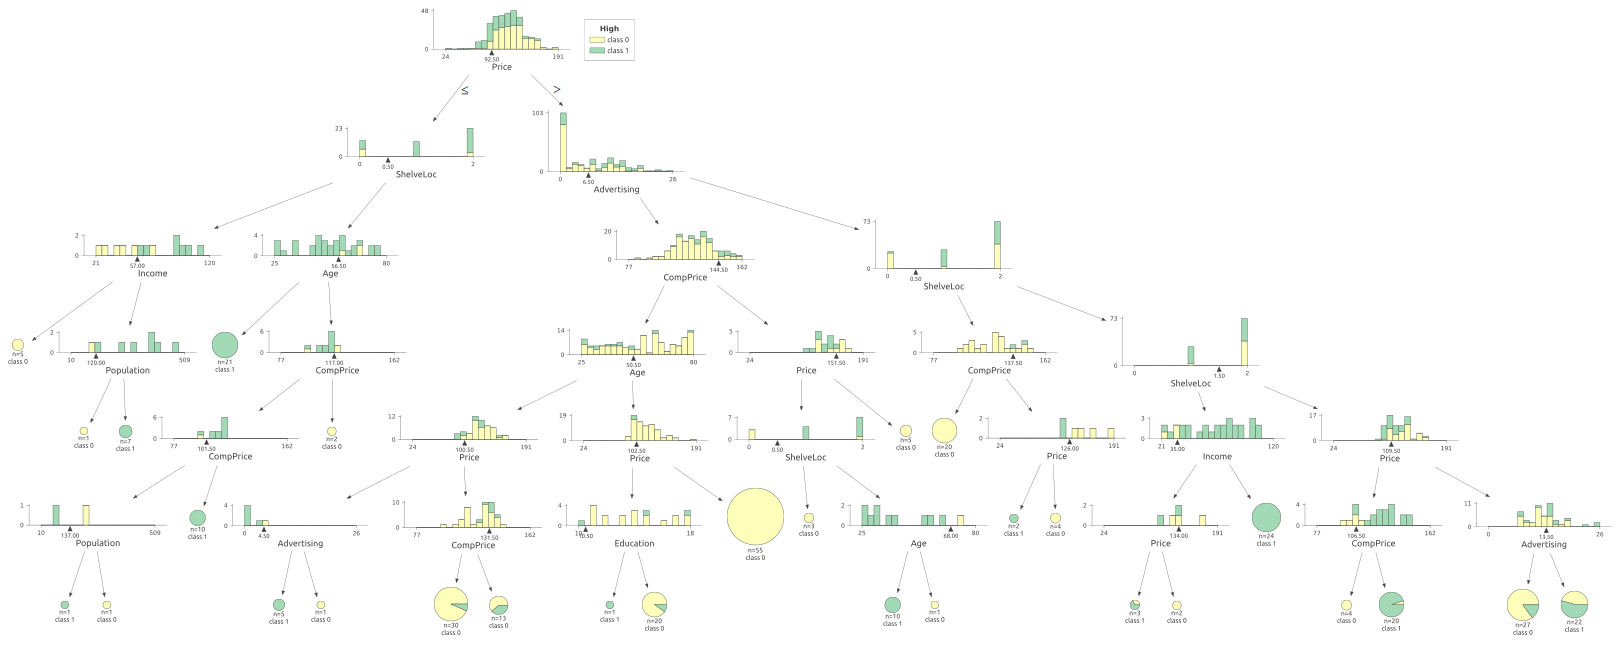

In [16]:
dtreeviz(
    classification_tree_carseats, 
    X_train.values, 
    y_train,
    feature_names=X_train.columns,
    target_name=y_train.name, 
    scale=1,
    fontname='ubuntu'
    )

## Tree on test data

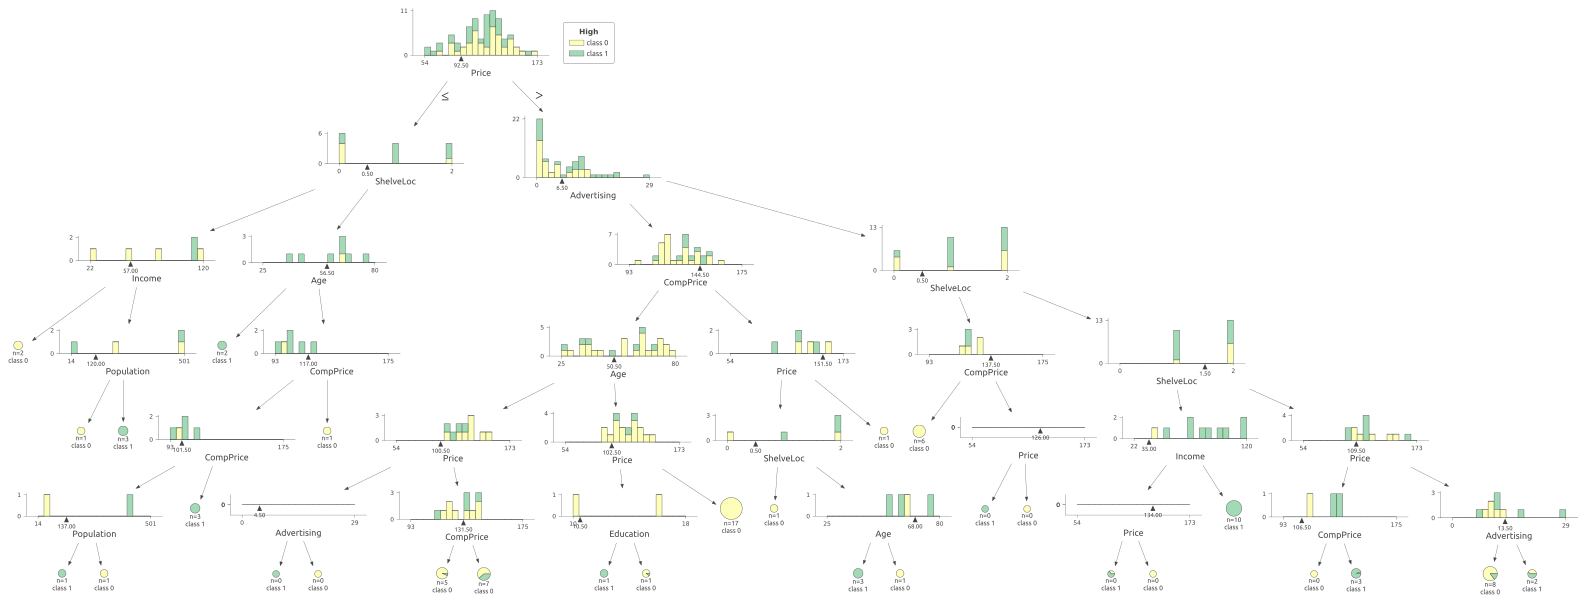

In [17]:
dtreeviz(
    classification_tree_carseats, 
    X_test.values, 
    y_test,
    feature_names=X_train.columns,
    target_name=y_train.name, 
    scale=1,
    fontname='ubuntu'
    )

In [78]:
# export_graphviz(classification_tree_carseats, 
#                 out_file = "carseat_tree.dot", 
#                 feature_names = X_train.columns)

# with open("carseat_tree.dot") as f:
#     dot_graph = f.read()
# graphviz.Source(dot_graph)

The most important indicator of `High` sales appears to be `Price`.

Finally, let's evaluate the tree's performance on
the test data. The `predict()` function can be used for this purpose. We can then build a confusion matrix, which shows that we are making correct predictions for
around 72.5% of the test data set:

In [14]:
confusion_matrix?

Signature:
confusion_matrix(
    y_true,
    y_pred,
    *,
    labels=None,
    sample_weight=None,
    normalize=None,
)
Docstring:
Compute confusion matrix to evaluate the accuracy of a classification.

By definition a confusion matrix :math:`C` is such that :math:`C_{i, j}`
is equal to the number of observations known to be in group :math:`i` and
predicted to be in group :math:`j`.

Thus in binary classification, the count of true negatives is
:math:`C_{0,0}`, false negatives is :math:`C_{1,0}`, true positives is
:math:`C_{1,1}` and false positives is :math:`C_{0,1}`.

Read more in the :ref:`User Guide <confusion_matrix>`.

Parameters
----------
y_true : array-like of shape (n_samples,)
    Ground truth (correct) target values.

y_pred : array-like of shape (n_samples,)
    Estimated targets as returned by a classifier.

labels : array-like of shape (n_classes), default=None
    List of labels to index the matrix. This may be used to reorder
    or select a subset of labels.
    If

In [18]:
pred = classification_tree_carseats.predict(X_test.values)
cm = pd.DataFrame(
    confusion_matrix(y_true=y_test, y_pred=pred), 
    index = ['No', 'Yes'], 
    columns = ['No', 'Yes']
)
cm.index.name = 'True'
cm.columns.name = 'Predicted'
print(cm)
# (37+21)/80 = 0.745

Predicted  No  Yes
True              
No         36    7
Yes        16   21


# 8.3.2 Fitting Regression Trees

Now let's try fitting a **regression tree** to the `Boston` data set from the `MASS` library. First, we create a
training set, and fit the tree to the training data using `medv` (median home value) as our response:

In [57]:
#boston_df = pd.read_csv('Boston.csv')
from sklearn.datasets import load_boston
boston_df = ISLR2data('Boston')

X = boston_df.drop('medv', axis = 1)
X_names = X.columns
X = X.values
y = boston_df.medv
y_name = 'median value'
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 0)

# Pruning not supported. Choosing max depth 2)
regr_tree_boston = DecisionTreeRegressor(max_depth = 2)
regr_tree_boston.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=2)

Let's take a look at the tree:

In [58]:
from sklearn.tree import export_text
print(export_text(regr_tree_boston, feature_names=list(boston_df.drop('medv', axis = 1).columns)))

|--- lstat <= 8.13
|   |--- rm <= 7.44
|   |   |--- value: [28.55]
|   |--- rm >  7.44
|   |   |--- value: [44.93]
|--- lstat >  8.13
|   |--- lstat <= 15.00
|   |   |--- value: [21.60]
|   |--- lstat >  15.00
|   |   |--- value: [14.45]



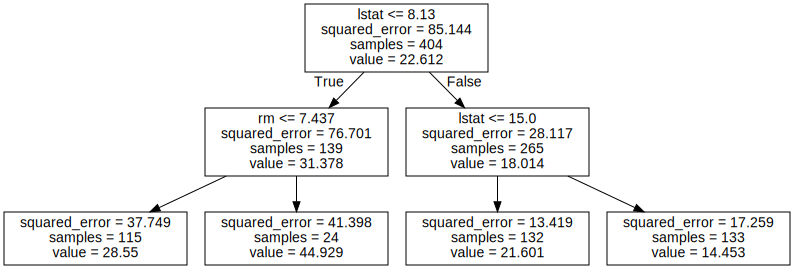

In [59]:
export_graphviz(regr_tree_boston,
                out_file = "boston_tree.dot", 
                feature_names = X_names,
                )

with open("boston_tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

In [61]:
y_train.var(ddof=0)

85.1437202235075

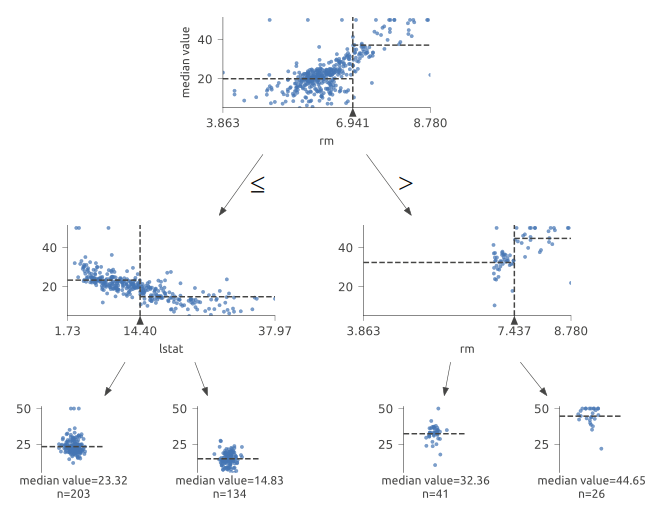

In [55]:
dtreeviz(
    regr_tree_boston, 
    X_train, 
    y_train, 
    feature_names = X_names, 
    target_name = y_name,
    scale=2, 
    label_fontsize=8,
    fontname='ubuntu'
)

The variable `lstat` measures the percentage of individuals with lower
socioeconomic status. The tree indicates that lower values of `lstat` correspond
to more expensive houses. The tree predicts a median house price
of \$44,93 for larger homes (`rm>=7.437`) in suburbs in which residents have high socioeconomic
status (`lstat<8.13`).

Now let's see how it does on the test data:

35.406215828790266

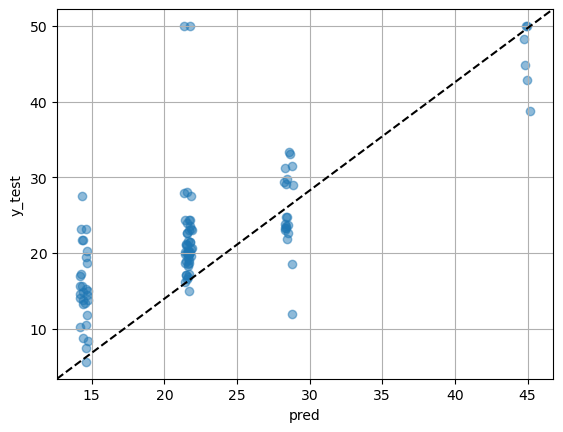

In [62]:
pred = regr_tree_boston.predict(X_test)

plt.scatter(
    pred+np.random.uniform(-0.3,0.3,size=pred.shape), 
    y_test, 
    label = 'medv', 
    alpha=0.5
    )

plt.plot(
    [0, 1], 
    [0, 1], 
    '--k', 
    transform = plt.gca().transAxes
    )

plt.xlabel('pred')
plt.ylabel('y_test')
plt.grid()

mean_squared_error(y_test, pred)

The test set MSE associated with the regression tree is
35.4. The square root of the MSE is therefore around 5.95, indicating
that this model leads to test predictions that are within around \$5,950 of
the true median home value for the suburb.
    
# 8.3.3 Bagging and Random Forests

Let's see if we can improve on this result using **bagging** and **random forests**. The exact results obtained in this section may
depend on the version of `python` and the version of the `RandomForestRegressor` package
installed on your computer, so don't stress out if you don't match up exactly with the book. Recall that **bagging** is simply a special case of
a **random forest** with $m = p$. Therefore, the `RandomForestRegressor()` function can
be used to perform both random forests and bagging. Let's start with bagging:

In [63]:
# Bagging: using all features
bagged_boston = RandomForestRegressor(max_features = X_train.shape[1], random_state = 1)
bagged_boston.fit(X_train, y_train)

RandomForestRegressor(max_features=12, random_state=1)

The argument `max_features = X_train.shape[1]` indicates that all predictors should be considered
for each split of the tree -- in other words, that bagging should be done. How
well does this bagged model perform on the test set?

20.629888323529418

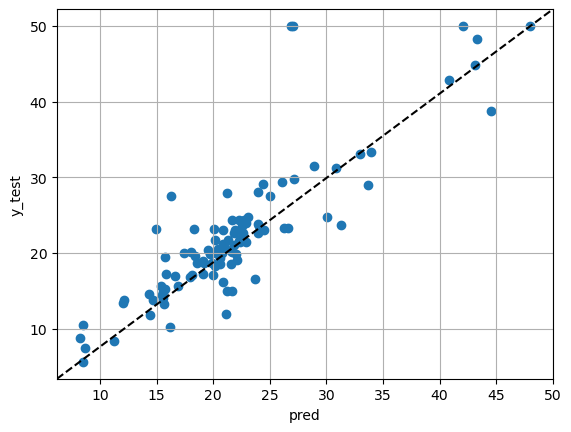

In [65]:
pred = bagged_boston.predict(X_test)

plt.scatter(
    pred, 
    y_test, 
    label = 'medv'
    )

plt.plot(
    [0, 1], 
    [0, 1], 
    '--k', 
    transform = plt.gca().transAxes
    )

plt.xlabel('pred')
plt.ylabel('y_test')
plt.grid()

mean_squared_error(y_test, pred)

The test set MSE associated with the bagged regression tree is significantly lower than our single tree!

We can grow a random forest in exactly the same way, except that
we'll use a smaller value of the `max_features` argument. Here we'll
use `max_features = 6`:

In [88]:
# Random forests: using 6 features
random_forest_boston = RandomForestRegressor(max_features=6, random_state=1)

random_forest_boston.fit(X_train, y_train)

pred = random_forest_boston.predict(X_test)
mean_squared_error(y_test, pred)

24.502028284313734

In [82]:
random_forest_boston.n_estimators

100

The test set MSE is somewhat bigger.
The result depends heavily on the split, in other words the random state parameter given to the `train_test_split` function.

Using the `feature_importances_` attribute of the `RandomForestRegressor`, we can view the importance of each
variable:

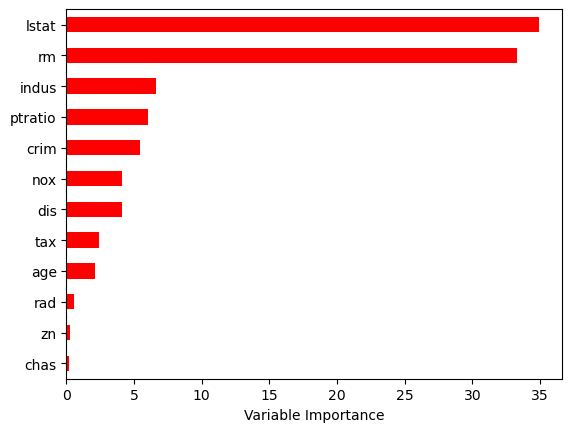

In [72]:
Importance = pd.DataFrame(
    {
        'Importance': random_forest_boston.feature_importances_*100
    }, 
    index=X_names
    )

Importance.sort_values(
    by='Importance', 
    axis=0, 
    ascending=True
    ).plot(
        kind = 'barh', 
        color = 'r', 
    )

plt.xlabel('Variable Importance')
plt.gca().legend_ = None

The results indicate that across all of the trees considered in the random
forest, the wealth level of the community (`lstat`) and the house size (`rm`)
are by far the two most important variables.

# 8.3.4 Boosting

Now we'll use the `GradientBoostingRegressor` package to fit **boosted
regression trees** to the `Boston` data set. The
argument `n_estimators = 500` indicates that we want 500 trees, and the option
`interaction.depth = 4` limits the depth of each tree:

In [89]:
boosted_boston = GradientBoostingRegressor(
    n_estimators = 500, 
    learning_rate = 0.01, 
    max_depth = 4, 
    random_state = 1
    )

boosted_boston.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.01, max_depth=4, n_estimators=500,
                          random_state=1)

Let's check out the feature importances again:

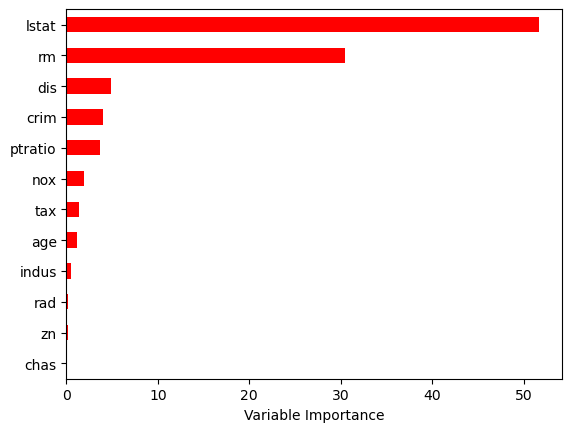

In [90]:
feature_importance = boosted_boston.feature_importances_*100

rel_imp = pd.Series(feature_importance, 
                    index = X_names).sort_values(inplace = False)

rel_imp.T.plot(kind = 'barh', 
               color = 'r', )

plt.xlabel('Variable Importance')

plt.gca().legend_ = None

We see that `lstat` and `rm` are again the most important variables by far. Now let's use the boosted model to predict `medv` on the test set:

In [91]:
mean_squared_error(y_test, boosted_boston.predict(X_test))

19.386873465952963

The test MSE obtained is similar to the test MSE for random forests
and superior to that for bagging. If we want to, we can perform boosting
with a different value of the shrinkage parameter $\lambda$. Here we take $\lambda = 0.2$:

In [92]:
boosted_boston2 = GradientBoostingRegressor(
    n_estimators = 1000, 
    learning_rate = 0.025, 
    max_depth = 3, 
    random_state = 1
    )
    
boosted_boston2.fit(X_train, y_train)

mean_squared_error(y_test, boosted_boston2.predict(X_test))

15.932528122366826

15.932528122366826

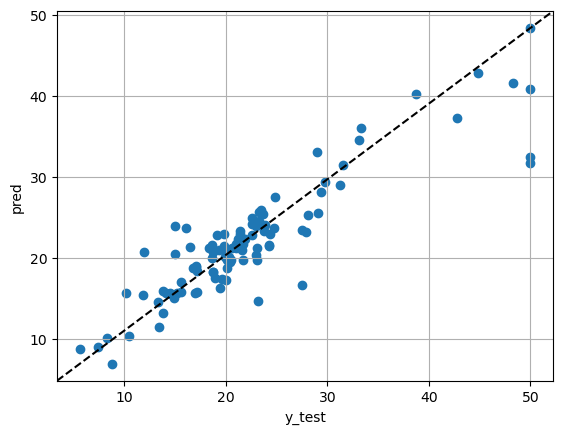

In [98]:
pred = boosted_boston2.predict(X_test)

plt.scatter(
    y_test, 
    pred, 
    label = 'medv'
    )

plt.plot(
    [0, 1], 
    [0, 1], 
    '--k', 
    transform = plt.gca().transAxes
    )

plt.ylabel('pred')
plt.xlabel('y_test')
plt.grid()

mean_squared_error(y_test, pred)

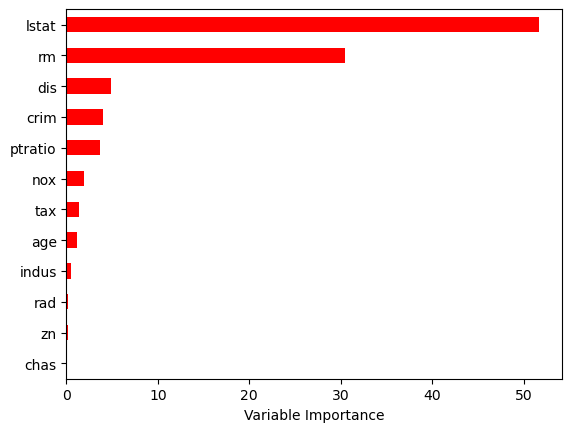

In [105]:
feature_importance = boosted_boston.feature_importances_*100

rel_imp = pd.Series(feature_importance, 
                    index = X_names).sort_values(inplace = False)

rel_imp.T.plot(kind = 'barh', 
               color = 'r', )

plt.xlabel('Variable Importance')

plt.gca().legend_ = None